In [50]:
# spark functions 
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# helper libraries 
from collections import defaultdict
import hashlib
import numpy as np
import datetime as DT
from math import exp, log

# pandas
import pandas as pd

# plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [3]:
def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

def parseHashPoint(point, numBuckets, delim):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    splits = point.split(delim)
    fields = [ (i,v) for i,v in enumerate(splits[1:]) ]
    vec = SparseVector(numBuckets, hashFunction(numBuckets, fields))
    return LabeledPoint(splits[0], vec)

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p==0:
        p+=epsilon
    elif p==1:
        p-=epsilon
    if y==1:
        return -log(p)
    elif y==0:
        return -log(1-p)
    else:
        raise Exception('y not in {0,1}')

def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    probs = data.map(lambda x: (getP(x.features, model.weights, model.intercept), x.label))
    logloss = probs.map(lambda x: computeLogLoss(x[0],x[1])).reduce(lambda x,y: x+y) / probs.count()
    return logloss

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w)+intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1.0/(1+exp(-rawPrediction))

In [4]:
train_data_location = 's3n://criteo-dataset/rawdata/train'
test_data_location = 's3n://criteo-dataset/rawdata/test'
validation_data_location = 's3n://criteo-dataset/rawdata/validation'

In [ ]:
train_data = sc.textFile(train_data_location).cache()
validation_data = sc.textFile(validation_data_location).cache()
test_data = sc.textFile(test_data_location).cache()

In [5]:
hashTrainData = train_data.map(lambda x: parseHashPoint(x, 1000, '\t')).cache()
hashValidationData = validation_data.map(lambda x: parseHashPoint(x, 1000, '\t')).cache()
hashTestData = test_data.map(lambda x: parseHashPoint(x, 1000, '\t')).cache()

In [6]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# fixed hyperparameters
numIters = 50
stepSize = 10.
regParam = 0.
regType = 'l2'
includeIntercept = True

starttime = DT.datetime.now()
model0 = LogisticRegressionWithSGD.train( data= hashTrainData
                                         , iterations= numIters
                                         , step= stepSize
                                         , regParam= regParam
                                         , regType= 'l2'
                                         , intercept= includeIntercept )
endtime = DT.datetime.now()
runtime = (endtime-starttime).seconds
runtime_hours = runtime // 3600
runtime_minutes = (runtime % 3600) // 60
runtime_seconds = (runtime % 3600) % 60
print 'job finished in {} hours, {} minutes and {} seconds'.\
        format(runtime_hours, runtime_minutes, runtime_seconds)

job finished in 0 hours, 15 minutes and 5 seconds


#### EMR Setup:
<table style='align: left'>
<tr>
<td><strong>Node type</strong></td>
<td><strong>Count</strong></td>
<td><strong>Intance</strong></td>
</tr>
<tr>
<td>Master</td>
<td>1</td>
<td>r3.xlarge</td>
</tr>
<tr>
<td>Core</td>
<td>7</td>
<td>r3.xlarge</td>
</tr>
</table>

In [16]:
# Compute raw scores on the validation set
predictionAndLabelsTrain = hashTrainData.map(lambda lp: (float(model0.predict(lp.features)), lp.label))
predictionAndLabelsVal = hashValidationData.map(lambda lp: (float(model0.predict(lp.features)), lp.label))
predictionAndLabelsTest = hashTestData.map(lambda lp: (float(model0.predict(lp.features)), lp.label))

# Instantiate metrics object
metricsTrain = BinaryClassificationMetrics(predictionAndLabelsTrain)
metricsVal = BinaryClassificationMetrics(predictionAndLabelsVal)
metricsTest = BinaryClassificationMetrics(predictionAndLabelsTest)

# Area under ROC curve
print("Area under ROC, Train = %s" % metricsTrain.areaUnderROC)
print("Area under ROC, Validation = %s" % metricsVal.areaUnderROC)
print("Area under ROC, Test = %s" % metricsTest.areaUnderROC)

Area under ROC, Train = 0.651420018788
Area under ROC, Validation = 0.651397081537
Area under ROC, Test = 0.651683988549


In [17]:
# Evaluate Log-Loss
loglossTrain = evaluateResults(model0,hashTrainData)
loglossVal = evaluateResults(model0,hashValidationData)
loglossTest = evaluateResults(model0,hashTrainData)

# Log-loss results
print("Log-loss, Train = %s" % loglossTrain)
print("Log-loss, Validation = %s" % loglossVal)
print("Log-loss, Test = %s" % loglossTest)

Log-loss, Train = 0.556543482585
Log-loss, Validation = 0.556640268951
Log-loss, Test = 0.556543482585


#### Model results table
<table>
<tr>
<th>Metric</th>
<th>Dataset</th>
<th>Result</th>
</tr>
<tr>
<td>AUC</td>
<td>Train</td>
<td>65.14%</td>
</tr>
<tr>
<td>AUC</td>
<td>Validation</td>
<td>65.14%</td>
</tr>
<tr>
<td>AUC</td>
<td>Test</td>
<td>65.17%</td>
</tr>
<tr>
<td>Log-loss</td>
<td>Train</td>
<td>55.65%</td>
</tr>
<tr>
<td>Log-loss</td>
<td>Validation</td>
<td>55.66%</td>
</tr>
<tr>
<td>Log-loss</td>
<td>Test</td>
<td>55.65%</td>
</tr>
</table>

### HW 13.5: Criteo Phase 2 hyperparameter tuning  
>SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please used them and build on them.
 

>Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

>-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

>-- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
-- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
-- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

>Discuss the optimal setting to solve this problem  in terms of the following:
-- Features
-- Learning algortihm
-- Spark cluster

>Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.



In [27]:
hashBuckets = [ 1000, 5000, 10000 ]
regTerms = [ 1e-6, 1e-3, 1e-2] 
stepSizes = [ 1, 10, 100 ]
results = {}
results['hashBuckets'] = []
results['regTerms'] = []
results['stepSizes'] = []
results['validationAUC'] = []
results['validationLogLoss'] = []

starttime = DT.datetime.now()
for h in hashBuckets:
    # load data
    hashTrainData = train_data.map(lambda x: parseHashPoint(x, h, '\t')).cache()
    hashValidationData = validation_data.map(lambda x: parseHashPoint(x, h, '\t')).cache()
    
    for r in regTerms:
        for s in stepSizes:
            results['hashBuckets'].append(h)
            results['regTerms'].append(r)
            results['stepSizes'].append(s)
            
            # run model 
            model = LogisticRegressionWithSGD.train( data= hashTrainData
                                         , iterations= 10
                                         , step= s
                                         , regParam= r
                                         , regType= 'l2'
                                         , intercept= True )
            
            # calculation binary classification metrics 
            predictionAndLabelsVal = hashValidationData. \
                                        map(lambda lp: (float(model.predict(lp.features)), lp.label))
            metricsVal = BinaryClassificationMetrics(predictionAndLabelsVal)
            
            # calculate log-loss
            loglossVal = evaluateResults(model, hashValidationData)
            
            # store results
            results['validationAUC'].append(metricsVal.areaUnderROC)
            results['validationLogLoss'].append(loglossVal)
            
endtime = DT.datetime.now()
runtime = (endtime-starttime).seconds
runtime_hours = runtime // 3600
runtime_minutes = (runtime % 3600) // 60
runtime_seconds = (runtime % 3600) % 60
print 'job finished in {} hours, {} minutes and {} seconds'.\
        format(runtime_hours, runtime_minutes, runtime_seconds)

job finished in 1 hours, 24 minutes and 27 seconds


#### Figure 1: Table of Grid-search results

In [29]:
pd.DataFrame(results)

,hashBuckets,regTerms,stepSizes,validationAUC,validationLogLoss
0,1000,0.000001,1,0.500208,0.543713
1,1000,0.000001,10,0.617106,1.128304
2,1000,0.000001,100,0.500000,5.126996
3,1000,0.001000,1,0.500199,0.543741
4,1000,0.001000,10,0.500001,1.610130
5,1000,0.001000,100,0.500000,5.126856
6,1000,0.010000,1,0.500151,0.543995
7,1000,0.010000,10,0.501479,1.066049
8,1000,0.010000,100,0.500000,5.126996
9,5000,0.000001,1,0.500485,0.543310


In [35]:
result_df = pd.DataFrame(results)
bestresult = result_df['validationLogLoss']==np.min(result_df['validationLogLoss'])
result_df[bestresult]

,hashBuckets,regTerms,stepSizes,validationAUC,validationLogLoss
18,10000,0.000001,1,0.500542,0.543222


In [36]:
# use best results
hashBuckets = 10000
regTerm = 0.000001
stepSize = 1

# build datasets with best grid-search results
hashTrainData = train_data.map(lambda x: parseHashPoint(x, hashBuckets, '\t')).cache()
hashValidationData = validation_data.map(lambda x: parseHashPoint(x, hashBuckets, '\t')).cache()
hashTestData = test_data.map(lambda x: parseHashPoint(x, hashBuckets, '\t')).cache()

# create LR model 
modelGS = LogisticRegressionWithSGD.train( data= hashTrainData
                                         , iterations= 100
                                         , step= stepSize
                                         , regParam= regTerm
                                         , regType= 'l2'
                                         , intercept= True )

In [42]:
# get model results for all datasets
predictionAndLabelsTrain = hashTrainData. \
                            map(lambda lp: (float(modelGS.predict(lp.features)), lp.label))
predictionAndLabelsVal = hashValidationData. \
                            map(lambda lp: (float(modelGS.predict(lp.features)), lp.label))
predictionAndLabelsTest = hashTestData. \
                            map(lambda lp: (float(modelGS.predict(lp.features)), lp.label))
metricsTrain = BinaryClassificationMetrics(predictionAndLabelsTrain)
metricsVal = BinaryClassificationMetrics(predictionAndLabelsVal)
metricsTest = BinaryClassificationMetrics(predictionAndLabelsTest)

# calculate log-loss
loglossTrain = evaluateResults(modelGS, hashTrainData)
loglossVal = evaluateResults(modelGS, hashValidationData)
loglossTest = evaluateResults(modelGS, hashTestData)

# store results
bestresults = {}
bestresults['hashBuckets'] = hashBuckets
bestresults['regTerm'] = regTerm
bestresults['stepSize'] = stepSize
bestresults['AUCtrain'] = metricsTrain.areaUnderROC
bestresults['AUCvalidation'] = metricsVal.areaUnderROC
bestresults['AUCtest'] = metricsTest.areaUnderROC
bestresults['LogLosstrain'] = loglossTrain
bestresults['LogLossvalidation'] = loglossVal
bestresults['LogLosstest'] = loglossTest

In [43]:
bestresults

{'AUCtest': 0.5272941767928676,
 'AUCtrain': 0.5271317711642737,
 'AUCvalidation': 0.5273112353305975,
 'LogLosstest': 0.5218620652196896,
 'LogLosstrain': 0.521725934571774,
 'LogLossvalidation': 0.5219043589740324,
 'hashBuckets': 10000,
 'regTerm': 1e-06,
 'stepSize': 1}

In [52]:
regTerms = [ 1e-6, 1e-5, 1e-3, 1e-2, 1e-1] 
stepSizes = [ 0.1, 1, 5, 10, 12, 15 ]
pairresults = {}
pairresults['regTerms'] = []
pairresults['stepSizes'] = []
pairresults['validationAUC'] = []
pairresults['validationLogLoss'] = []

starttime = DT.datetime.now()
for r in regTerms:
    for s in stepSizes:
        pairresults['regTerms'].append(r)
        pairresults['stepSizes'].append(s)

        # run model 
        model = LogisticRegressionWithSGD.train( data= hashTrainData
                                     , iterations= 10
                                     , step= s
                                     , regParam= r
                                     , regType= 'l2'
                                     , intercept= True )

        # calculation binary classification metrics 
        predictionAndLabelsVal = hashValidationData. \
                                    map(lambda lp: (float(model.predict(lp.features)), lp.label))
        metricsVal = BinaryClassificationMetrics(predictionAndLabelsVal)

        # calculate log-loss
        loglossVal = evaluateResults(model, hashValidationData)

        # store results
        pairresults['validationAUC'].append(metricsVal.areaUnderROC)
        pairresults['validationLogLoss'].append(loglossVal)

endtime = DT.datetime.now()
runtime = (endtime-starttime).seconds
runtime_hours = runtime // 3600
runtime_minutes = (runtime % 3600) // 60
runtime_seconds = (runtime % 3600) % 60
print 'job finished in {} hours, {} minutes and {} seconds'.\
        format(runtime_hours, runtime_minutes, runtime_seconds)

job finished in 0 hours, 42 minutes and 28 seconds


#### Figure 2: Step-size vs. Regularization Log-loss Heatmap

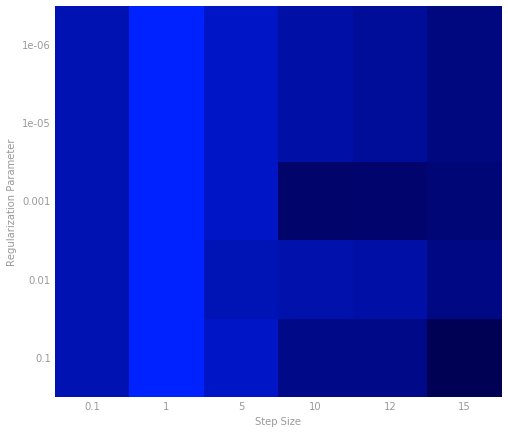

In [59]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

numRows, numCols = len(regTerms), len(stepSizes)
logLoss = np.array( pairresults['validationLogLoss'] )
logLoss.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7),
                      hideLabels=True, gridWidth=0.)
ax.set_yticklabels(regTerms), ax.set_xticklabels(stepSizes)
ax.set_ylabel('Regularization Parameter'), ax.set_xlabel('Step Size')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(logLoss,interpolation='nearest', aspect='auto',
                    cmap = colors)

In [55]:
pd.DataFrame(pairresults)

,regTerms,stepSizes,validationAUC,validationLogLoss
0,0.000001,0.1,0.514633,0.629371
1,0.000001,1.0,0.500542,0.543222
2,0.000001,5.0,0.640529,0.568661
3,0.000001,10.0,0.539296,0.698795
4,0.000001,12.0,0.642367,0.863599
5,0.000001,15.0,0.615934,1.530889
6,0.000010,0.1,0.514633,0.629371
7,0.000010,1.0,0.500542,0.543223
8,0.000010,5.0,0.640528,0.568666
9,0.000010,10.0,0.537596,0.704557


During testing it was clear that larger bucket sizes and smaller step sizes resulted in better log-loss and AUC. In my initial grid-search testing (Figure 1), the best result was the highest bucket-size tested (10,000), and lowest regularization parameter and step-size of 1. In my second test -- isolated to step-size and regularization -- it became clear again that step-size of 1 was better than the tested lower value of 0.1 and any higher value. It became clear also that regularization values tested had little affect on the validation-tested results at a step-size of 1. 